# Association Rule: Heuristic Approach

#### Loading necessary libraries

In [1]:
import pandas as pd
import os
import string
from nltk.corpus import stopwords
from collections import Counter 
from itertools import combinations, permutations

## 1. Reading data

### 1.1 Reading features for each of the paragraphs - Entities and Sentiments

In [2]:
#text_feat = pd.read_csv("text_features.csv",encoding='ISO-8859-1')

In [3]:
#text_feat.head()

### 1.2 Reading the actual content of each paragraph

In [279]:
textdatanew = pd.read_csv("textdatanew.csv",encoding='ISO-8859-1')
textdatanew.head()

,CollectionID,BiographyID,ParagraphNo,ParagraphText
0,a001,bio04,1,"A FRENCH philosopher, moralizing on the great ..."
1,a001,bio04,2,Cleopatra was joint heir to the throne of Egyp...
2,a001,bio04,3,Cleopatra might have responded with a brillian...
3,a001,bio04,4,Caesar was then above fifty years of age. His ...
4,a001,bio04,5,For three years Cleopatra reigned with little ...


## 2. Analyzing and Processing data

Splitting the paragraph to have each word in a single record

In [5]:
textdatanew['Word_split'] = textdatanew.ParagraphText.apply(lambda x: ''.join(s for s in x if s not in string.punctuation).split(" "))

In [6]:
textdatanew.head()

,CollectionID,BiographyID,ParagraphNo,ParagraphText,Word_split
0,a001,bio04,1,"A FRENCH philosopher, moralizing on the great ...","[A, FRENCH, philosopher, moralizing, on, the, ..."
1,a001,bio04,2,Cleopatra was joint heir to the throne of Egyp...,"[Cleopatra, was, joint, heir, to, the, throne,..."
2,a001,bio04,3,Cleopatra might have responded with a brillian...,"[Cleopatra, might, have, responded, with, a, b..."
3,a001,bio04,4,Caesar was then above fifty years of age. His ...,"[Caesar, was, then, above, fifty, years, of, a..."
4,a001,bio04,5,For three years Cleopatra reigned with little ...,"[For, three, years, Cleopatra, reigned, with, ..."


In [7]:
text_stack = textdatanew.apply(lambda x: pd.Series(x['Word_split']), axis=1).stack().reset_index(level=1, drop=True)

In [8]:
text_stack.name = 'Word_splits'
textdatanew2 = textdatanew.drop(['ParagraphText','Word_split'], axis=1).join(text_stack)
textdatanew2['Word_splits'] = pd.Series(textdatanew2['Word_splits'], dtype=object)
#textdatanew2

Creating a Unique identifier for each of the paragraph

In [244]:
textdatanew2['Unique_id'] = textdatanew2.CollectionID+"_"+textdatanew2.BiographyID+"_"+textdatanew2.ParagraphNo.apply(str)

#textdatanew2['Unique_id'] = textdatanew2.CollectionID+"_"+textdatanew2.BiographyID

In [245]:
### Removing extra columns
Text_Para = textdatanew2.drop(['CollectionID','BiographyID','ParagraphNo'], axis = 1).drop_duplicates()

In [246]:
Text_Para.head()

,Word_splits,Unique_id
0,A,a001_bio04_1
0,FRENCH,a001_bio04_1
0,philosopher,a001_bio04_1
0,moralizing,a001_bio04_1
0,on,a001_bio04_1


In [268]:
word_counts = Counter(Text_Para.Word_splits.apply(lambda x: x.lower()))
most_common_words = [each[0] for each in word_counts.most_common(100)]
#word_counts.most_common(100)

In [248]:
Text_Para['Word_freq'] = Text_Para.Word_splits.apply(lambda x: word_counts[x.lower()])

#### Distribution of words greater than minimum and less than maximum threshold

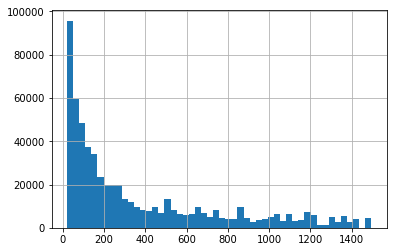

In [249]:
p = Text_Para.Word_freq[(Text_Para.Word_freq>20) & (Text_Para.Word_freq < 1500)].hist(bins = 50)

In [250]:
Text_Para.tail()

,Word_splits,Unique_id,Word_freq
16636,still,p091C_bio19_103,1181
16636,bloomed,p091C_bio19_103,8
16636,for,p091C_bio19_103,8790
16636,Lola,p091C_bio19_103,512
16636,Montez,p091C_bio19_103,186


In [251]:
#### Upper Threshold determined after selecting top 100 values
Text_para_final = Text_Para[(Text_Para.Word_freq > 20)  & (Text_Para.Word_freq < 1500)]

In [252]:
#Text_para_final.head()

In [253]:
Text_para_final.loc[:,'Words_clean'] = Text_para_final.Word_splits.apply(lambda x: x.lower())
Text_Para.loc[:,'Words_clean'] = Text_Para.Word_splits.apply(lambda x: x.lower())

C:\Users\arvra\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\arvra\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [254]:
Text_para_final.shape

(600612, 4)

In [255]:
# Counter iterates through the item pairs returned by our generator and keeps a tally of their occurrence
#word_pairs = Counter(get_item_pairs(Text_para_final))

In [256]:
total_ids = len(Text_para_final.Unique_id.unique())

In [257]:
total_ids

16611

### Association Rule Mining

#### Support

In [258]:
### Support Dictionary 

support = {}
for pairs,freq_count in word_pairs.items():
    ### Sorting the tuple so that we don't have entries like (a,b) and (b,a) separately
    support[tuple(sorted(pairs))] = freq_count/total_ids

In [259]:
len(support)

4544489

#### Confidence

In [260]:
#### For confience we need support(A,B) and support(A). we have values of support(A,B) from the previous value
#### Need to find the support value for support(A)

In [261]:
# supp = pd.DataFrame(Text_para_final.loc[:,['Unique_id','Words_clean']].drop_duplicates().\
#                         groupby(['Words_clean'])['Unique_id'].count())

In [262]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().as_matrix()
    #print(order_item)
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]   

In [263]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [264]:
import pandas as pd
import numpy as np
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

Words = Text_para_final[['Unique_id','Words_clean']].drop_duplicates().set_index('Unique_id')['Words_clean'].rename('item_id')

In [265]:
%%time
rules = association_rules(Words, 0.01)  

Starting order_item:                 597887
Items with support >= 0.01:            5767
Remaining order_item:                597887
Remaining orders with 2+ items:       16510
Remaining order_item:                597786
Item pairs:                         7999094
Item pairs with support >= 0.01:    3193579

Wall time: 1min 2s


In [280]:
rules

,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
152246,annie,luke,17,0.102968,21,0.127196,24,0.145366,0.809524,0.708333,5.568849
1869438,ne,pas,12,0.072683,21,0.127196,25,0.151423,0.571429,0.480000,3.773714
1469954,jenny,lind,33,0.199879,42,0.254391,36,0.218050,0.785714,0.916667,3.603373
489937,christina,rossetti,15,0.090854,31,0.187765,25,0.151423,0.483871,0.600000,3.195484
2444522,schoolmistress,woolston,13,0.078740,23,0.139310,33,0.199879,0.565217,0.393939,2.827800
784221,drury,lane,20,0.121139,21,0.127196,65,0.393701,0.952381,0.307692,2.419048
2091012,philip,ferdinand,12,0.072683,25,0.151423,34,0.205936,0.480000,0.352941,2.330824
2092938,physically,mentally,9,0.054512,29,0.175651,22,0.133253,0.310345,0.409091,2.328997
2851038,thã©rã¨se,humbert,19,0.115082,40,0.242277,36,0.218050,0.475000,0.527778,2.178403
312880,bianca,francesco,10,0.060569,32,0.193822,24,0.145366,0.312500,0.416667,2.149740


In [129]:
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")
    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))

In [133]:
# Calculate item frequency and support
item_stats             = freq(Text_para_final).to_frame("freq")
item_stats['support']  = item_stats['freq'] / order_count(Text_para_final) * 100

In [136]:
Text_para_final

,Word_splits,Unique_id,Word_freq,Words_clean
0,FRENCH,a001_bio04_1,396,french
0,influence,a001_bio04_1,410,influence
0,matters,a001_bio04_1,135,matters
0,remarked,a001_bio04_1,99,remarked
0,end,a001_bio04_1,663,end
0,Cleopatras,a001_bio04_1,27,cleopatras
0,nose,a001_bio04_1,53,nose
0,changed,a001_bio04_1,107,changed
0,history,a001_bio04_1,316,history
0,Rome,a001_bio04_1,173,rome


In [50]:
### Now, getting the confidence of every pair

def conf(support):
    conf = {}
    
    for key,value in support.items():
        #### Getting the confidence for {A -> B}
        conf[(key[0],key[1])] = support[key]/supp.loc[key[1],:]

        #### Getting the confidence for {B -> A}
        conf[(key[1],key[0])] = support[key]/supp.loc[key[0],:]
        
        yield conf

In [51]:
a = conf(support)

In [54]:
b = list(a)

#### Lift Calculation

In [34]:
len(support)

5974864

#### Reducing the vocabulary size to avoid memory error

In [74]:
### Checking the vocabulary size of the data
len(Text_Para.Word_splits.unique())

61994

Finding high frequency and low frequency words

In [100]:
high_freq_threshold = 5000
low_freq_threshold = 10

In [102]:
high_freq_words = Text_Para.Word_splits.value_counts()[Text_Para.Word_splits.value_counts() > top_freq_threshold].index
low_freq_words = Text_Para.Word_splits.value_counts()[Text_Para.Word_splits.value_counts() < low_freq_threshold].index

In [138]:
### Clean stopwords
clean_stop_words = ''.join([each for each in 'ZZ'.join(stopwords.words('english')) if each not in string.punctuation]).split("ZZ")

In [139]:
clean_stop_words.extend(list(low_freq_words))
clean_stop_words.extend(list(high_freq_words))

In [177]:
words_to_remove = list(set(clean_stop_words))
words_to_remove_upper = [each.split()[0].upper() for each in words_to_remove]